In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
metricsDir = './out/metrics'
graphsDir = './out/graphs'
df = pd.read_excel('results-javascript.xlsx')

In [2]:
def numericalMetrics(df,column,metricRows,metricsDir,graphsDir):
    mean = df[column].mean()
    median = df[column].median()
    stdev = df[column].std()
    stats = f'{column}\nMean: {mean}\nMedian: {median}\nStdDev: {stdev}'
    metricRows.append([column,mean,median,stdev])
    boxplot(df,column,graphsDir)

def boxplot(df,column,graphsDir):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 *IQR)
    df_filtered = df.loc[filter]
    ax = df_filtered.boxplot(column,rot=10)
    ax.set_xlabel("")
    ax.set_ylabel(f"# of {column}")
    ax.set_title(column)
    # plt.show()
    fig = ax.get_figure()
    fig.savefig(f'./out/graphs/{column}.pdf')

def boolMetrics(df,column,boolRows,metricsDir,graphsDir):
    trueCount = df[column].sum()
    falseCount = (~df[column]).sum()
    total = df[column].shape[0]
    truePercentage = round((trueCount / total)*100,2)
    falsePercentage = round((falseCount / total)*100,2)
    boolRows.append([column,trueCount,falseCount,truePercentage,falsePercentage])

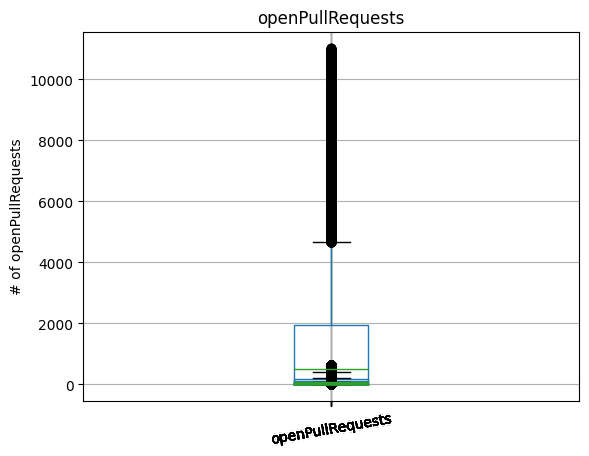

In [3]:
metricRows = []
boolRows = []
for col in df.columns:
    if df.dtypes[col] == 'int64':
        numericalMetrics(df,col,metricRows,metricsDir,graphsDir)
    elif df.dtypes[col] == 'bool':
        boolMetrics(df,col,boolRows,metricsDir,graphsDir)
metricsDF = pd.DataFrame(columns=["Metric","Mean","Median","StdDev"],data=metricRows)
boolDF = pd.DataFrame(columns=["Metric","True Count","False Count","True Percentage","False Percentage"],data=boolRows)
metricsDF.to_csv('./out/metrics/numericalMetrics.csv',index=False)
boolDF.to_csv('./out/metrics/boolMetrics.csv',index=False)

In [4]:
metricsDF

,Metric,Mean,Median,StdDev
0,commits,403.261891,107.0,1407.357441
1,branches,9.859782,3.0,39.171386
2,releases,17.779972,7.0,59.019702
3,contributors,11.350802,5.0,29.640616
4,watchers,20.072478,7.0,79.573109
5,stargazers,411.776143,50.0,2032.143878
6,forks,74.056509,14.0,469.134762
7,size,17389.014784,838.0,225132.826940
8,totalIssues,81.213143,15.0,382.875238
9,openIssues,16.113671,4.0,71.578183


In [5]:
boolDF

,Metric,True Count,False Count,True Percentage,False Percentage
0,isFork,367,57871,0.63,99.37
1,hasWiki,46399,11839,79.67,20.33
2,isArchived,4128,54110,7.09,92.91


In [6]:
#this data is pretty useless ignore this code block
metricColumns = ["commits","branches","releases","contributors","watchers","stargazers","forks","size","totalIssues","openIssues","totalPullRequests","openPullRequests"]
boolColumns = ["isFork","hasWiki","isArchived"]
boolCorrMatrix = df.corr().loc[metricColumns,boolColumns]
boolCorrMatrix.to_csv('./out/metrics/boolCorrMatrix.csv')
boolCorrMatrix

,isFork,hasWiki,isArchived
commits,0.056058,-0.052605,0.001425
branches,0.006534,-0.016180,0.000015
releases,-0.002622,-0.063137,0.015698
contributors,0.075003,-0.097156,0.014375
watchers,-0.009557,-0.051191,0.031544
stargazers,-0.009255,-0.061592,-0.014150
forks,-0.005603,-0.033382,-0.005349
size,0.007913,0.003170,-0.004973
totalIssues,-0.000889,-0.058219,0.000471
openIssues,0.001959,-0.029707,-0.005651


In [7]:
metricColumns = ["commits","branches","releases","contributors","size","totalIssues","openIssues","totalPullRequests","openPullRequests"]
popularityMetrics = ["stargazers","forks","watchers"]
popCorrMatrix = df.corr().loc[metricColumns,popularityMetrics]
popCorrMatrix.to_csv('./out/metrics/popCorrMatrix.csv')
popCorrMatrix

,stargazers,forks,watchers
commits,0.236677,0.214683,0.206367
branches,0.077002,0.055199,0.064181
releases,0.130682,0.095880,0.097811
contributors,0.529803,0.410877,0.351932
size,0.048344,0.032899,0.032787
totalIssues,0.564858,0.451327,0.396611
openIssues,0.418982,0.317621,0.290393
totalPullRequests,0.304151,0.302366,0.238072
openPullRequests,0.228722,0.205353,0.147012


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
linearTables = {}
linear_models = {}
for p in popularityMetrics:
    Q1 = df[p].quantile(0.25)
    Q3 = df[p].quantile(0.75)
    IQR = Q3 - Q1
    outlierfilter = (df[p] >= Q1 - 1.5 * IQR) & (df[p] <= Q3 + 1.5 *IQR)
    x_train,x_test,p_train,p_test = train_test_split(df.loc[outlierfilter][metricColumns],df.loc[outlierfilter][p],test_size=0.5,random_state=10)
    model = LinearRegression()
    model.fit(x_train,p_train)
    p_training_pred = model.predict(x_train)
    p_test_pred = model.predict(x_test)
    linear_models[p] = model
    linearTables[p] = ["LinearRegression",mean_squared_error(p_test, p_test_pred),r2_score(p_test, p_test_pred)]
    print(f"RMSE for training model predicting {p}: {mean_squared_error(p_train, p_training_pred)**(1/2)}")
    print(f"RMSE for testing model predicting {p}: {mean_squared_error(p_test, p_test_pred)**(1/2)}")
    print(f"R^2 for training model predicting {p}: {r2_score(p_train, p_training_pred)}")
    print(f"R^2 for testing model predicting {p}: {r2_score(p_test, p_test_pred)}")
    linCoef = {x[0]: x[1] for x in (zip(metricColumns,model.coef_))}
    print(f"Coefficients for Linear Regression: {linCoef}")
    print()


RMSE for training model predicting stargazers: 78.51383209793678
RMSE for testing model predicting stargazers: 79.19804735929178
R^2 for training model predicting stargazers: 0.06015226715294808
R^2 for testing model predicting stargazers: 0.03582129572972814
Coefficients for Linear Regression: {'commits': -0.007098756610088183, 'branches': -0.08538144180219369, 'releases': 0.022334460653140924, 'contributors': 1.0166219490749064, 'size': -3.3469191633379965e-06, 'totalIssues': 0.06189068927209742, 'openIssues': 0.3274470710417151, 'totalPullRequests': -0.012715104476590177, 'openPullRequests': 0.8766746590220883}

RMSE for training model predicting forks: 17.256476249132582
RMSE for testing model predicting forks: 17.313283008966557
R^2 for training model predicting forks: 0.1379142600363792
R^2 for testing model predicting forks: 0.13241831186448694
Coefficients for Linear Regression: {'commits': -0.0021706452368068906, 'branches': -0.034884188925011834, 'releases': 0.013101057143547

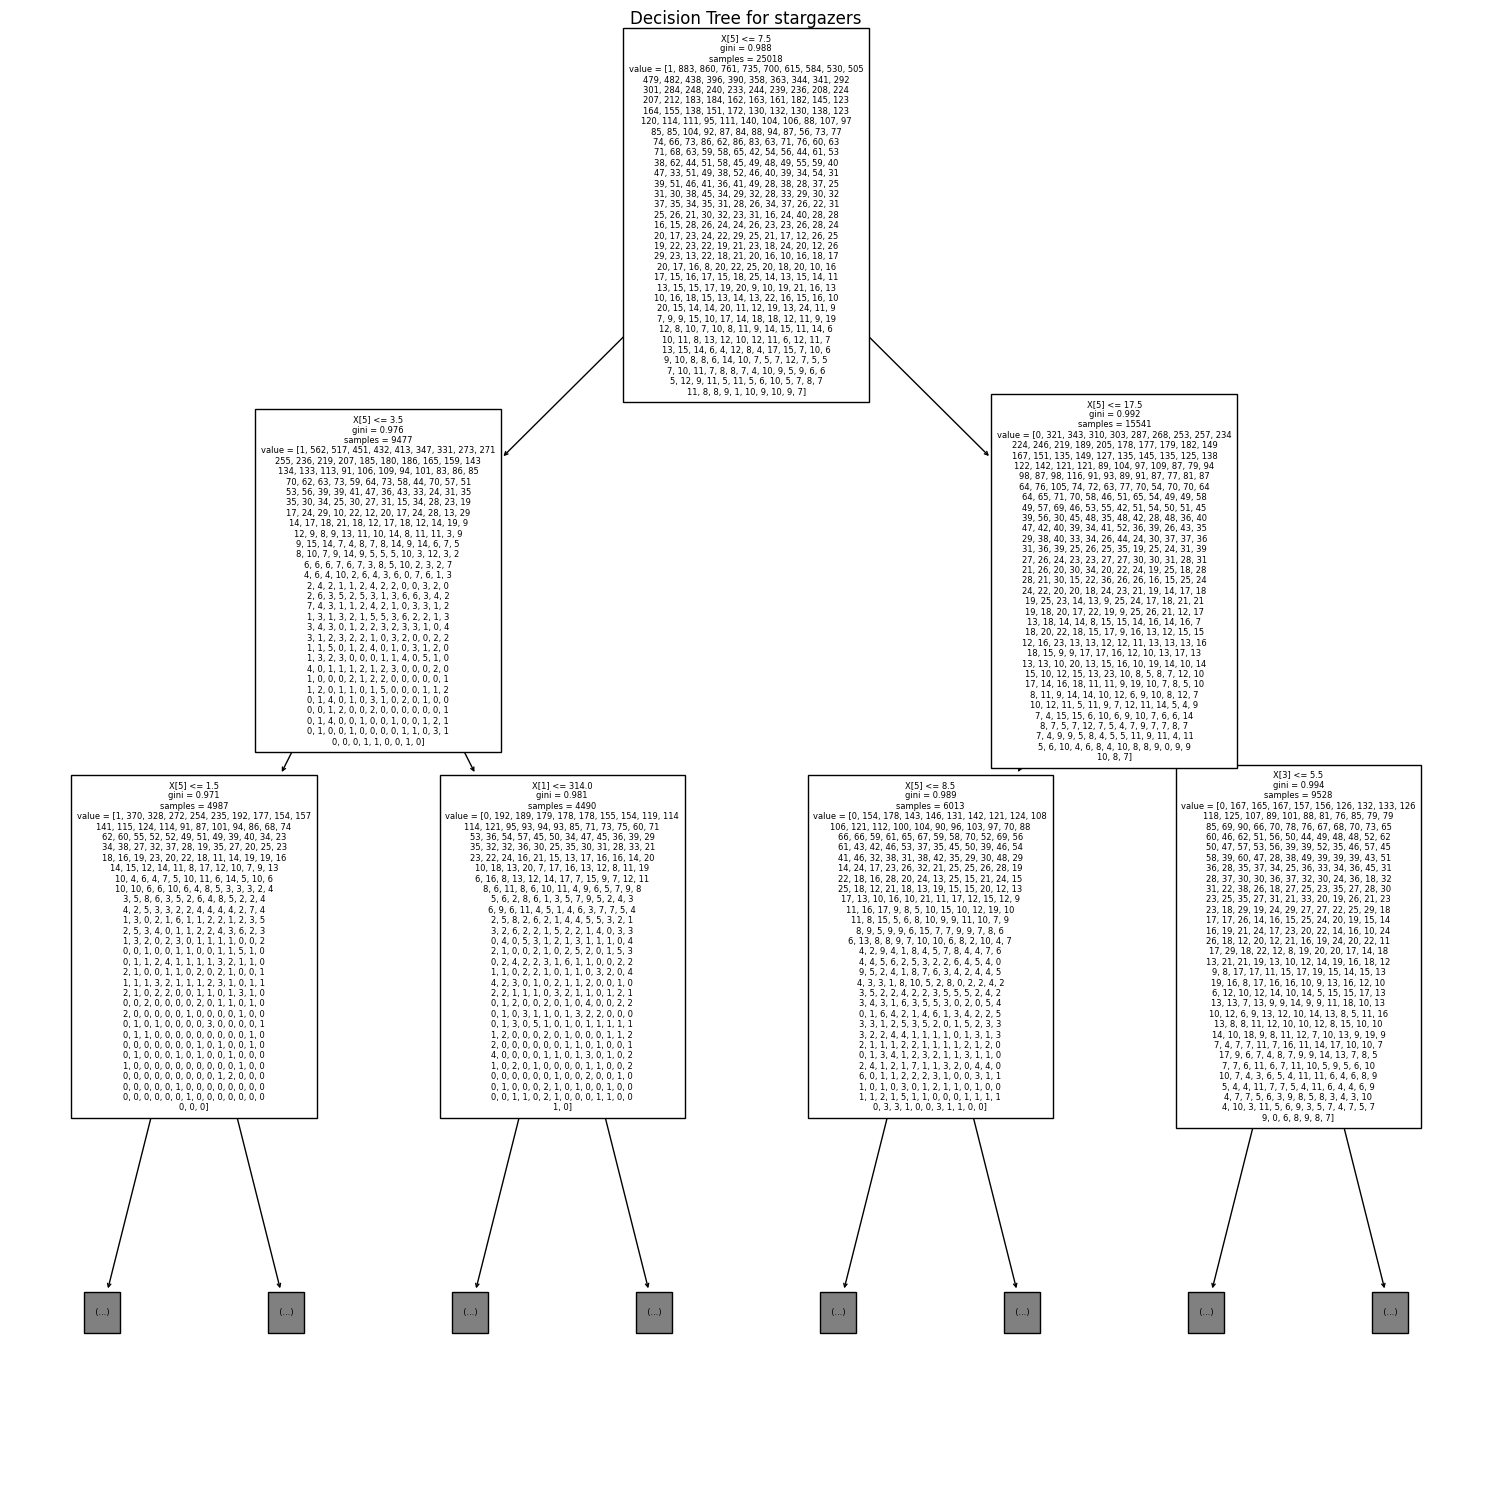

RMSE for training model predicting stargazers: 0.2915112609368939
RMSE for testing model predicting stargazers: 101.46987209433722
R^2 for training model predicting stargazers: 0.9999870438543875
R^2 for testing model predicting stargazers: -0.5827153436658798



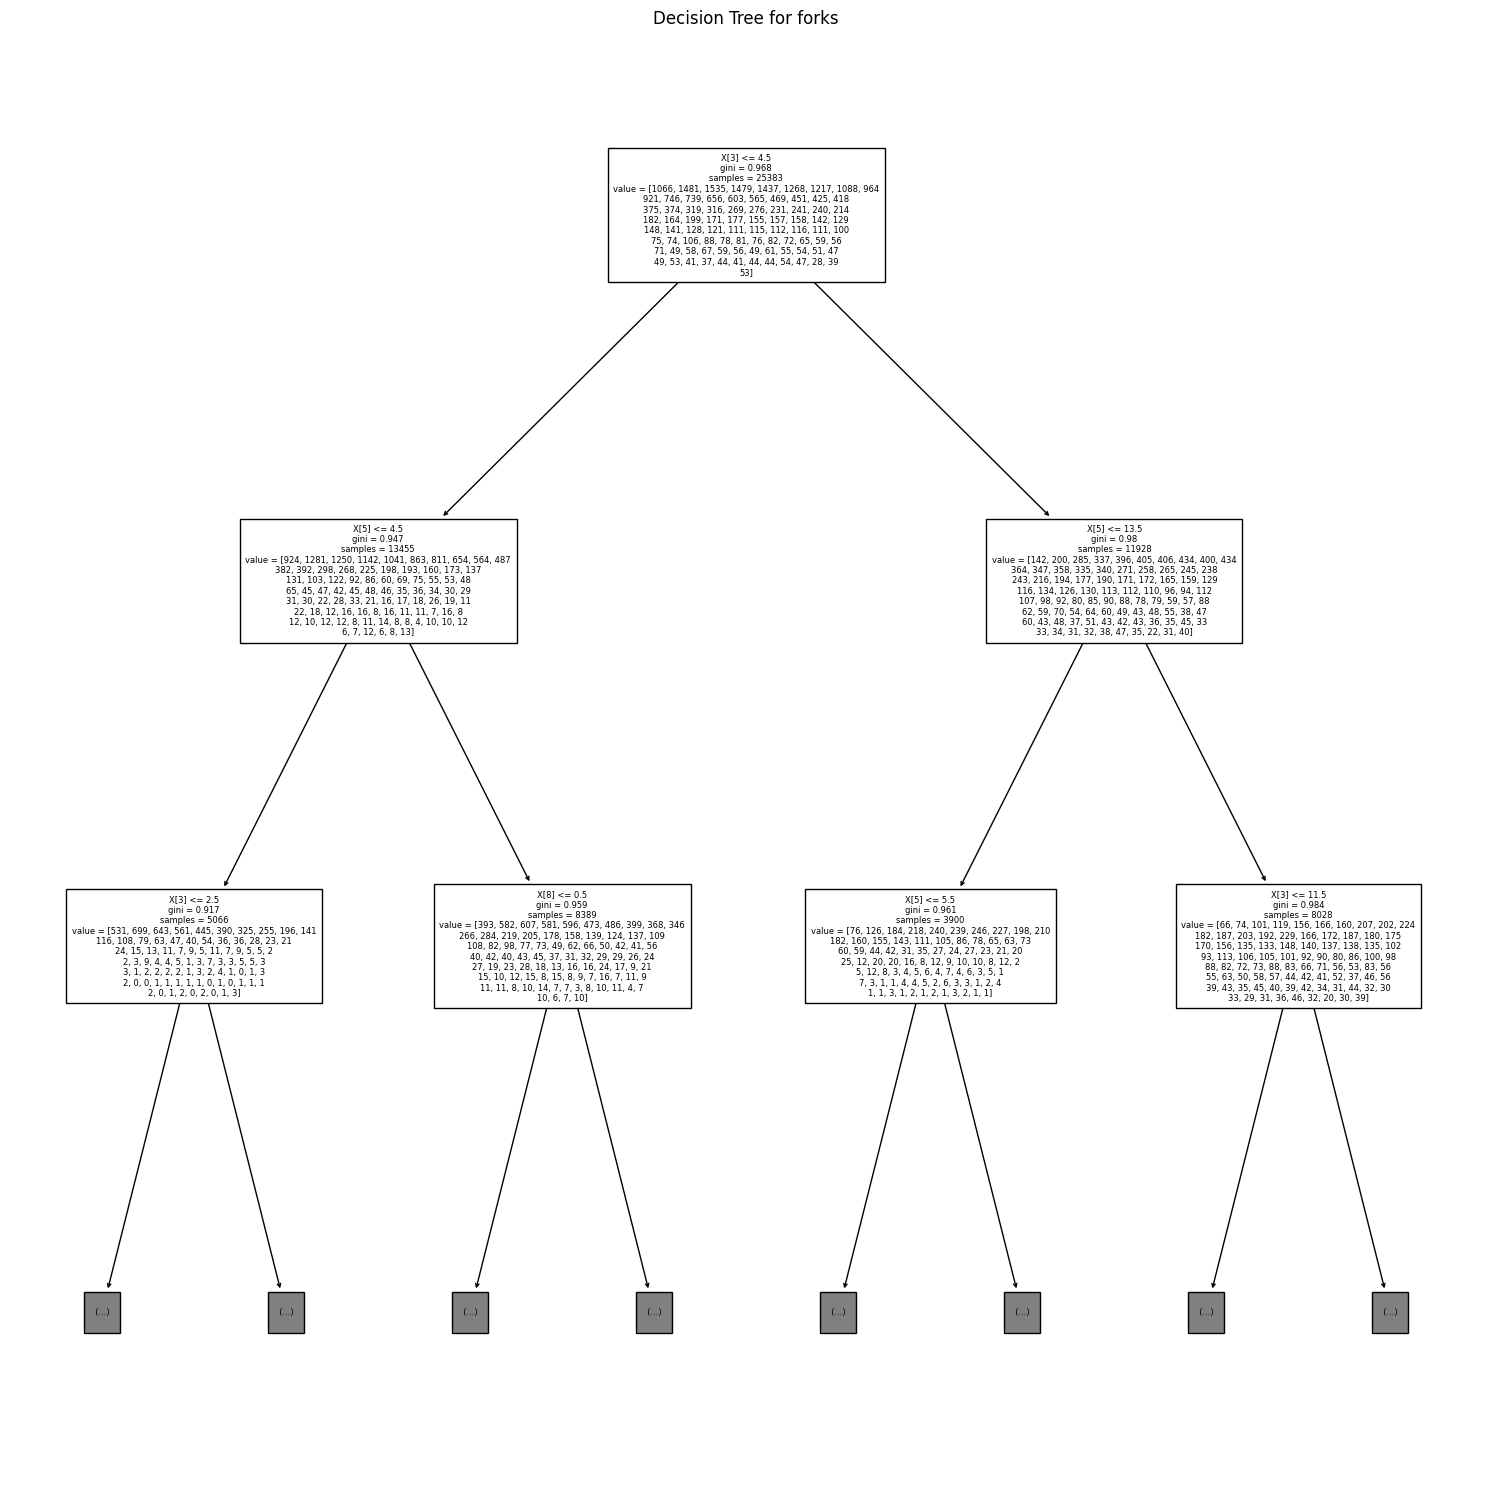

RMSE for training model predicting forks: 0.03969707618479279
RMSE for testing model predicting forks: 20.257297788652476
R^2 for training model predicting forks: 0.9999954379161125
R^2 for testing model predicting forks: -0.18772130082446803



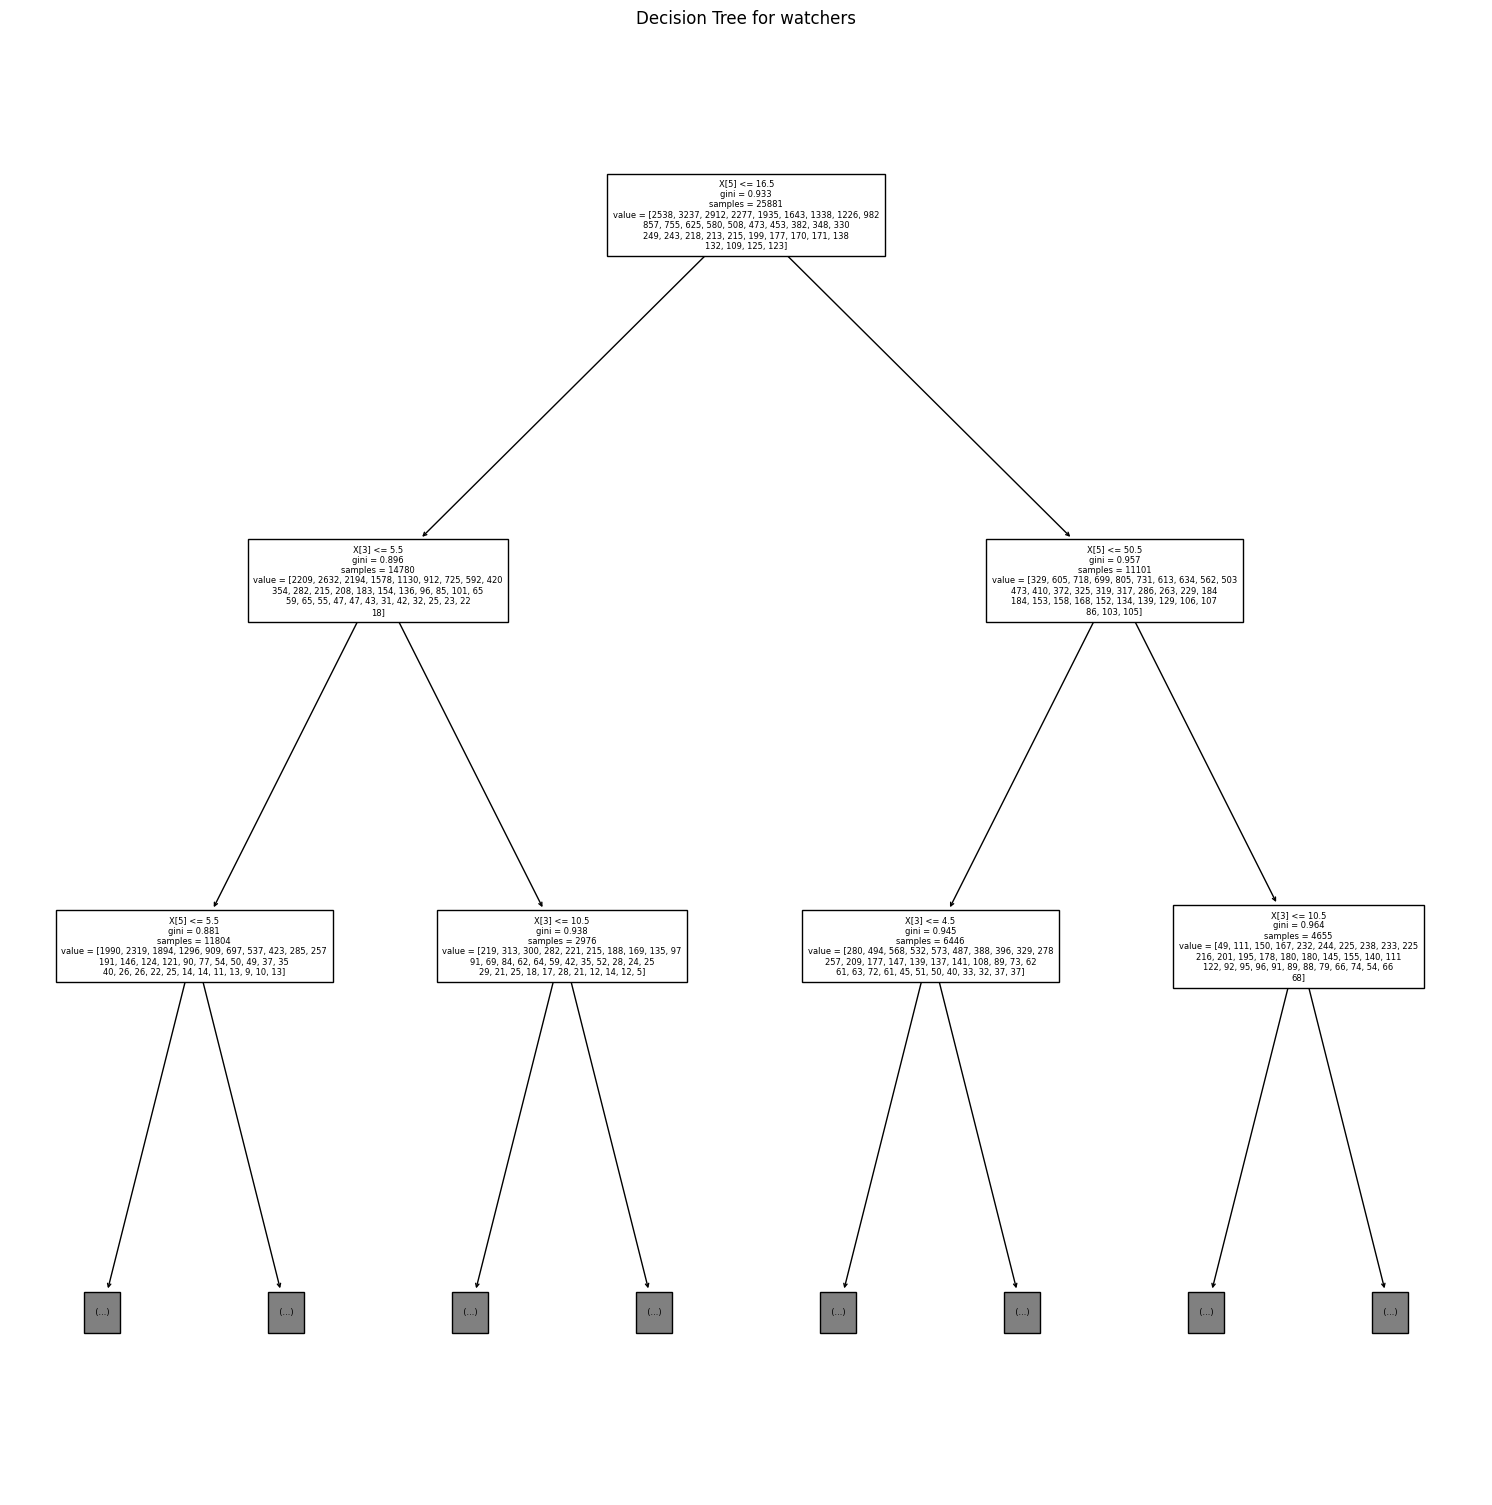

RMSE for training model predicting watchers: 0.019656648587701768
RMSE for testing model predicting watchers: 8.444545191733427
R^2 for training model predicting watchers: 0.999992782149281
R^2 for testing model predicting watchers: -0.35800241723947357



In [33]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
tree_models = {}
treeTables = {}
for p in popularityMetrics:
    Q1 = df[p].quantile(0.25)
    Q3 = df[p].quantile(0.75)
    IQR = Q3 - Q1
    outlierfilter = (df[p] >= Q1 - 1.5 * IQR) & (df[p] <= Q3 + 1.5 *IQR)
    x_train,x_test,p_train,p_test = train_test_split(df.loc[outlierfilter][metricColumns],df.loc[outlierfilter][p],test_size=0.5,random_state=10)
    model = DecisionTreeClassifier()
    model.fit(x_train,p_train)
    plt.figure(figsize=(19,19))
    plot_tree(model,max_depth=2,fontsize=6)
    plt.title(f"Decision Tree for {p}")
    plt.show()
    p_training_pred = model.predict(x_train)
    p_test_pred = model.predict(x_test)
    tree_models[p] = model
    treeTables[p] = ["DecisionTree",mean_squared_error(p_test, p_test_pred),r2_score(p_test, p_test_pred)]
    print(f"RMSE for training model predicting {p}: {mean_squared_error(p_train, p_training_pred)**(1/2)}")
    print(f"RMSE for testing model predicting {p}: {mean_squared_error(p_test, p_test_pred)**(1/2)}")
    print(f"R^2 for training model predicting {p}: {r2_score(p_train, p_training_pred)}")
    print(f"R^2 for testing model predicting {p}: {r2_score(p_test, p_test_pred)}")
    print()

In [10]:
starGazerTable = []
forkTable = []
watcherTable = []
starGazerTable.append(linearTables["stargazers"])
starGazerTable.append(treeTables["stargazers"])
forkTable.append(linearTables["forks"])
forkTable.append(treeTables["forks"])
watcherTable.append(linearTables["watchers"])
watcherTable.append(treeTables["watchers"])

starGazerTable = pd.DataFrame(columns=["stargazer","RMSE","R^2"],data=starGazerTable)
watcherTable = pd.DataFrame(columns=["watchers","RMSE","R^2"],data=watcherTable)
forkTable = pd.DataFrame(columns=["forks","RMSE","R^2"],data=forkTable)

In [11]:
starGazerTable

,stargazer,RMSE,R^2
0,LinearRegression,6272.330706,0.035821
1,DecisionTree,10224.717443,-0.571737


In [12]:
watcherTable

,watchers,RMSE,R^2
0,LinearRegression,45.824317,0.127342
1,DecisionTree,73.078900,-0.391682


In [13]:
forkTable

,forks,RMSE,R^2
0,LinearRegression,299.749769,0.132418
1,DecisionTree,403.601308,-0.168165
